In [1]:
using PyPlot
using Random
using LsqFit
using FStrings
using DataFrames

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1423
┌ Info: Precompiling FStrings [1e2663ae-5621-49ef-9c0a-672f85872094]
└ @ Base loading.jl:1423


In [2]:
P = zeros(50) .+ 0.30
P[1:10] = [0.5, 0.45, 0.45, 0.4, 0.4, 0.4, 0.35, 0.35, 0.35, 0.35];
#P = zeros(50) .+ 0.4; # FOR testing
#P = P .* (1 + 0.0256)

X(n) = P[n+1]
S(N) = N > 0 ? prod(X.(collect(0:(N-1)))) : 1 - X(0)
Z(N) = N > 0 ? (1-X(N))*prod(X.(collect(0:(N-1)))) : 1-X(0)
T(N) = N + 1
# Finally, the thing we're after. Average time to target
TimeToTarget(N) = (sum( Z.(0:N-1) .* T.(0:N-1) ) + S(N)*T(N-1))/S(N)

TimeToTargetProt(N, pro) = pro < N ? TimeToTargetProt(N-1)*10 : TimeToTarget(N)

## What else would we like? Average XP?
## Protection should be interesting, there is an infinite series of rapidly decreasing probability
## So we can use perterbation theory and take only Nth order terms. Start with N=1.

TimeToTargetProt (generic function with 1 method)

In [3]:
@show a=sum(S.(0:30).*(0:30))
@show b=sum(Z.(0:30).*T.(0:30))
@show a/b
@show S.(0:4)

a = sum(S.(0:30) .* (0:30)) = 1.5618055549999545
b = sum(Z.(0:30) .* T.(0:30)) = 1.892908544999967
a / b = 0.8250824156958845
S.(0:4) = [0.5, 0.5, 0.225, 0.10125, 0.04050000000000001]


5-element Vector{Float64}:
 0.5
 0.5
 0.225
 0.10125
 0.04050000000000001

In [4]:
## Simulated Values
function enhance(level)
    if rand() < P[level+1]
        return level + 1
    end
    return 0
end

function simulatedEnhance(target; trials=10_000)
    dataset = []
    for t in collect(1:trials)
        count = 0
        level = 0
        while level < target
            count += 1
            level = enhance(level)
        end
        push!(dataset, count)
    end
    return sum(dataset)/length(dataset)
end

function protected(level, select)
    if level < select
        return enhance(level)
    end
    if rand() < P[level+1]
        return level + 1
    end
    return max(0,level - 1)
end

mean(x) = sum(x) / length(x)

function simulatedProtected(target, select; trials=10_000, cost=60)
    # Cost is ratio of protection cost over enhance cost
    dataset = []
    actionset = []
    protectionset = []
    for t in collect(1:trials)
        count = 0
        level = 0
        actions = 0
        protections = 0
        while level < target
            if level >= select
                count += cost+1
                protections += 1
            else
                count += 1
            end
            actions += 1
            level = protected(level, select)
        end
        push!(dataset, count)
        push!(actionset, actions)
        push!(protectionset, protections)
    end
    return [mean(dataset), mean(actionset), mean(protectionset)]
end

function simulatedProtectedExp(select; trials=10_000, cost=60)
    dataset = []
    for t in collect(1:trials)
        experience = 0
        count = 0
        level = 0
        for t in collect(1:1000)
            if level >= select
                count += cost+1
            else
                count += 1
            end
            lastLevel = level
            level = protected(level, select)
            if level > lastLevel
                experience += level
            end
        end
        push!(dataset, experience/count)
    end
    return sum(dataset)/length(dataset)
end

function fastSim(target, select; trials=10_000)
    dataset = []
    if target <= select
        return TimeToTarget(target)
    end
    for t in collect(1:trials)
        count = TimeToTarget(select)
        level = select
        while level < target
            level = protected(level, select)
            if level < select - 1
                # Reset and boost count
                count += TimeToTarget(select) + 1
                level = select
            else
                count += 1
            end
        end
        push!(dataset, count)
    end
    return sum(dataset)/length(dataset)
end

function simulatedAlpha(target; trials=10_000)
    dataset = []
    for t in collect(1:trials)
        resets = 0
        level = 0
        while level < target
            if( level == 0 )
                resets += 1
            end
            level = enhance(level)
        end
        push!(dataset, resets)
    end
    return sum(dataset)/length(dataset)
end

simulatedAlpha (generic function with 1 method)

In [8]:
x = simulatedProtected(10,6)

3-element Vector{Float64}:
 8493.2221
 4530.7441
   66.0413

In [6]:
simulatedProtectedExp(100)

0.8251780999999999

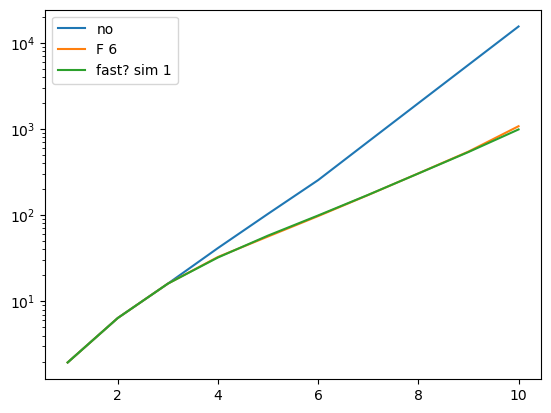

In [328]:
RunDown(N, pro) = pro < N ? RunDown(N-1, pro) + (1-X(N))^(N-pro+2)*X(N)^(N-pro+1) : (1-X(N))*X(N)^2
RunDown(N, pro) = pro < N ? RunDown(N-1, pro) + X(N)^(N-pro+1) : X(N)^(N-pro+1)
RunDown(N, pro) = sum( X.(pro:N).^(1:(N-pro+1)) )
RunDown(N, pro) = sum( X.((pro:N)).^((N-pro+1):-1:1) )
TimeFactor(N, pro) = sum( X.((pro:N)).^((N-pro+1):-1:1) )
TimeFactor(N, pro) = pro < 5 ? T(N) : 0
TimeToTargetProt(N, pro) = pro < N ? TimeToTargetProt(N-1, pro)/(RunDown(N,pro)+0.02*(1+1.5/(pro-N))) + T(N) : TimeToTarget(N)
TimeToTargetProt(N, pro) = pro < N ? TimeToTargetProt(N-1, pro)/(RunDown(N,pro)) + TimeFactor(N,pro) : TimeToTarget(N)

y = collect(1:10)
#plt.plot(y, α.(y))
plt.plot(y, TimeToTarget.(y), label="no")
#plt.plot(y, simulatedProtected.(y, 3; trials=10_000), label="simulated 3")
plt.plot(y, TimeToTargetProt.(y, 3), label="F 6")
#plt.plot(y, simulatedProtected.(y, 3; trials=10_000), label="simulated 1")
plt.plot(y, fastSim.(y, 3; trials=10_000), label="fast? sim 1")
#simset = simulatedProtected.(y, 1; trials=100_000)
#plt.plot(y, simulatedProtected.(y, 8; trials=10_000), label="simulated 8")
plt.legend()
plt.yscale("log")

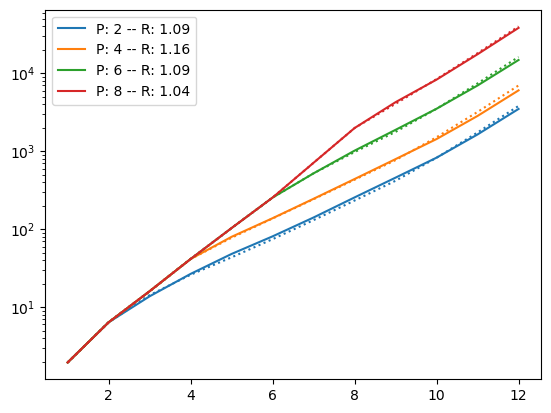

In [323]:
# Testing my slightly bullshit function
testsamples = 2:2:8
y = collect(1:12)
for t in testsamples
    Sims = fastSim.(y, t; trials=10_000)
    Funky = TimeToTargetProt.(y, t)
    ratio = Funky[end]/Sims[end]
    p0 = plt.plot(y, Sims, label=f"P: {t:0.0f} -- R: {ratio:0.2f}")
    clr = p0[1].get_color()
    plt.plot(y, Funky, linestyle=":", color=clr)
end
plt.legend()
plt.yscale("log")

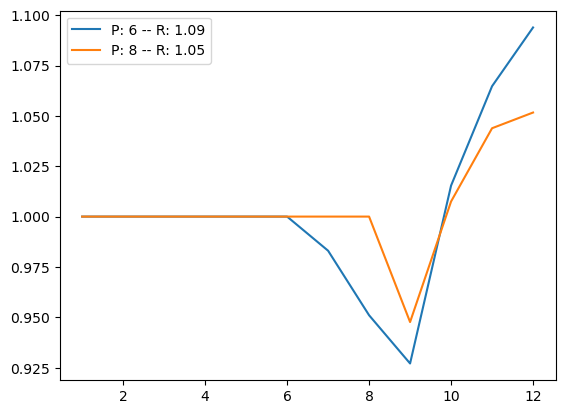

PyObject <matplotlib.legend.Legend object at 0x7f74a46ab940>

In [324]:
testsamples = 6:2:8 
y = collect(1:12)
for t in testsamples
    Sims = fastSim.(y, t; trials=10_000)
    Funky = TimeToTargetProt.(y, t)
    ratio = Funky[end]/Sims[end]
    #p0 = plt.plot(y, Sims, label=f"P: {t:0.0f} -- R: {ratio:0.2f}")
    #clr = p0[1].get_color()
    #plt.plot(y, Funky, linestyle=":", color=clr)
    p0 = plt.plot(y, Funky./Sims, label=f"P: {t:0.0f} -- R: {ratio:0.2f}")
end
plt.legend()
#plt.yscale("log")

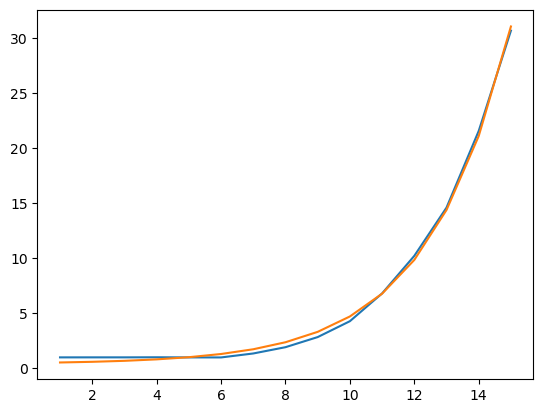

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f74b61c2e30>

In [7]:
@. model(x, p) = p[1]*exp(x/p[2]) + p[3]
fit = curve_fit(model, y, TimeToTarget.(y)./simset, [1/10.5,2.0,1.0])

plt.plot(y, TimeToTarget.(y)./simset)
plt.plot(y, model(y, fit.param) )